<div align="center">

#  **Задача "Anti-Fraud модель при кредитовании"**

</div>

!pip install pyarrow fastparquet s3fs openpyxl seaborn matplotlib scikit-learn lightgbm python-dotenv

In [15]:
import os
import pandas as pd
from dotenv import load_dotenv
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
pd.set_option('chained_assignment',None)
pd.set_option('display.max_columns', None)  

###  1. Обзор данных  

In [17]:
load_dotenv()
access_key = os.getenv("S3_ACCESS_KEY")
secret_key = os.getenv("S3_SECRET_KEY")

storage_options = {
    "key": access_key,
    "secret": secret_key,
    "client_kwargs": {
        "endpoint_url": "https://storage.yandexcloud.kz"
    }
}

def read_parquet_from_s3(s3_path, storage_options):
    try:
        return pd.read_parquet(s3_path, storage_options=storage_options)
    except Exception as e:
        print(f"Error reading {s3_path}: {e}")
        return None

s3_app_path = "s3://data-for-case-3/tabledata/train_data/train_app_data.parquet"
s3_target_path = "s3://data-for-case-3/tabledata/train_data/train_target_data.parquet"

df_app = read_parquet_from_s3(s3_app_path, storage_options)
df_target = read_parquet_from_s3(s3_target_path, storage_options)
df_merged = df_app.merge(df_target[['APPLICATIONID', 'target']], on='APPLICATIONID', how='inner')
df_merged.columns = df_merged.columns.str.strip()
df_merged.columns = df_merged.columns.str.replace(" ", "")

#### 1.1 Объединение данных

Разделим числовые данные, приведем в нужный формат

In [18]:
def clean_numeric(col):
    return pd.to_numeric(
        col.astype(str)
        .str.replace(" ", "", regex=False)
        .str.replace(",", ".", regex=False),
        errors="coerce"
    )

numeric_cols = [
    'TOTALAMOUNT',
    'SUM_CREDIT_KZT',
    'DM5DPD1GCVPSUM',
    'DM5DPD1SALARYSUM',
    'DM5EXPSUM',
    'DM5INCSUM',
    'DM5INC',
    'DM5EXP',
    'DM7INC',
    'DM7EXP',
    'DM6SCOREN6PD',
    'DM6SCOREN6',
    'FINALKDN',
    'CREDITTERM_RBL0',
    'CLI_AGE',
    'DEPENDANT_COUNT'
]
for col in numeric_cols:
    if col in df_merged.columns:
        df_merged[col] = clean_numeric(df_merged[col])

Рассмотрим нулевые значения

In [19]:
null_counts = df_merged.isnull().sum()
null_percent = df_merged.isnull().mean() * 100
null_summary = pd.DataFrame({
    'null_count': null_counts,
    'null_percent': null_percent
}).sort_values(by='null_percent', ascending=False)
null_summary = null_summary[null_summary['null_count'] > 0]
print(null_summary)


                     null_count  null_percent
DM5DPD1GCVPSUM             4156     22.604155
REGREGION                  3246     17.654737
DM5EXPSUM                   500      2.719460
DM5INCSUM                   498      2.708583
FINALKDN                    218      1.185685
REGTOWN                     195      1.060590
BIRTHCOUNTRY                 13      0.070706
MNG_NAME_LOGIN_INIT           7      0.038072
MNG_NAME_INIT                 7      0.038072
REGCOUNTY                     1      0.005439



Распределение фрод кейсов

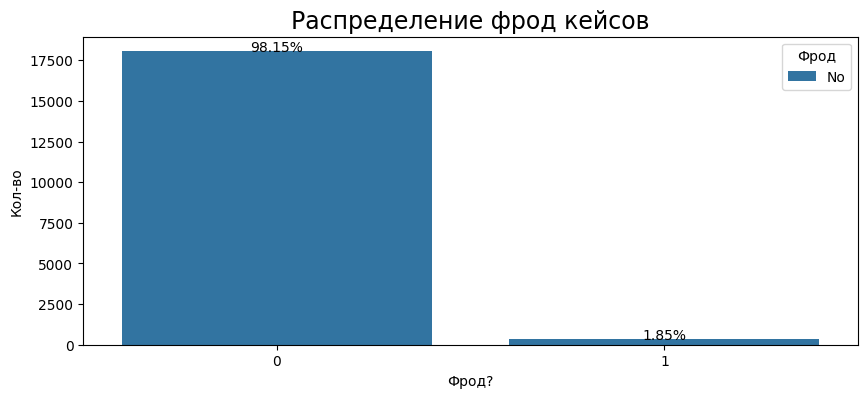

In [20]:
plt.figure(figsize=(10,4))
g = sns.countplot(x = 'target', data = df_merged)
g.set_title("Распределение фрод кейсов", fontsize = 17)
g.set_xlabel("Фрод?", fontsize = 10)
g.set_ylabel("Кол-во", fontsize = 10)
plt.legend(title='Фрод', labels=['No', 'Yes'])

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(df_merged) * 100),
            ha="center", fontsize=10) 

### Наблюдение
Процент мошеннических заявок составляет лишь 1.85% от всех записей, что указывает на наличие сильного дисбаланса классов. Такое соотношение между фродом и нефродом означает, что при обучении модели большинство алгоритмов будут склонны предсказывать "не фрод", что приведёт к высокой доле ложных отрицаний — мошеннические заявки будут ошибочно классифицированы как безопасные.

Возможные последствия:
- Модель может достичь высокой общей точности, но при этом не выявлять фрод.
- Повышенный риск ущерба от нераспознанных мошеннических кейсов.

Как справляться с дисбалансом:
- Методы, основанные на функции потерь:

Использовать class_weight='balanced' (например, в LogisticRegression, RandomForest, XGBoost).

Кастомная функция потерь с увеличением штрафа за ошибку на классе "фрод".

- Методы, основанные на ресемплинге:

Oversampling: SMOTE, ADASYN и др.

Undersampling: случайное уменьшение majority-класса.

Комбинации (например, SMOTE + Tomek Links).



## 2. EDA - Исследовательский анализ данных 

#### Рассмотрим категорийные фичи 

In [21]:
cat_cols = df_merged.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    fraud_rate = df_merged.groupby(col)['target'].mean().sort_values(ascending=False)
    print("            ")
    print(f" ----- Fraud rate for {col}:\n", fraud_rate.head(5))

            
 ----- Fraud rate for APPLICATIONID:
 APPLICATIONID
Д\286\012093151    1.0
Д\286\011769626    1.0
Д\286\011698001    1.0
Д\286\011519564    1.0
Д\286\012091823    1.0
Name: target, dtype: float64
            
 ----- Fraud rate for CREATE_DATETIME:
 CREATE_DATETIME
14.10.2024 11:37    1.0
14.11.2024 10:04    1.0
05.12.2024 19:41    1.0
04.12.2024 18:46    1.0
07.10.2024 9:36     1.0
Name: target, dtype: float64
            
 ----- Fraud rate for DATA_ISSUE:
 DATA_ISSUE
23.10.2024    0.065903
25.10.2024    0.063025
24.10.2024    0.048458
22.10.2024    0.047962
10.10.2024    0.036176
Name: target, dtype: float64
            
 ----- Fraud rate for VINTAGE:
 VINTAGE
2024_10    0.024331
2024_12    0.011084
2024_11    0.009858
Name: target, dtype: float64
            
 ----- Fraud rate for PRODUCT_GROUP:
 PRODUCT_GROUP
Доверительный    0.018492
Name: target, dtype: float64
            
 ----- Fraud rate for PURPOSE_LOAN:
 PURPOSE_LOAN
На рефинансирование займа и потребительские ц

По данным результаты можно сделать следующие выводы 

| Признак                                     | Почему полезен                                                                                                                                       |
| ------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- |
| `BKI`                                   | "Отсутствует" → 9.3% фрода vs "Плохая" → 0.7%. Это сильный признак!                                                                                  |
| `MNG_NAME_LOGIN_INIT` / `MNG_NAME_INIT` | Некоторые логины и ФИО явно связаны с фродом, возможно, плохие агенты. Можно сократить количество уникальных, сделав топ/остальные. |
| `SPF`                                   | Есть отделы с 33% фрода. Надо агрегировать редкие значения в "Other".                                                                                |
| `OPV_REASON`                            | `Онлайн СБОЛ` → почти 2% фрода vs `NEW САЙТ` → 0.4% — тоже различие.                                                                                 |
| `APPLICATION_ISA0AUTO`                  | `Улица` → 1.9% фрода vs `Зарплатники` → 0.18%. Чёткая разница.                                                                                       |
| `BRANCH` / `REGCOUNTY` / `REGTOWN`      | География влияет — можно использовать, возможно, с агрегацией (топ-10 + "другое").                                                                   |
| `COMPANY_NAME`                          | Некоторые имеют 100% фрода — стоит создать фичу "is\_blacklisted\_company".                                                                          |
| `BIRTHCOUNTRY`                          | Например, Украина и Таджикистан выше среднего по фроду.                                                                                              |
| `MARITALSTATUS`                         | Разведённые → 3.4%, остальные — \~1.6–1.8%. Отличие есть.                                                                                            |
| `KANAL_PRODAZH`                         | B-Bank (95% всех) — 2.6% фрода, другие ниже. Слабый, но стабильный признак.                                                                          |
| `VKI`                                   | "Отсутствует" выше, "Плохая" — 0%. Возможна полезность.                                                                                              |
| `COMPANY_NAME`                      | Много уникальных. Добавь бинарную фичу: `is_blacklisted_company` по тем, где фрод = 1. |
| `REGTOWN`, `REGREGION`, `REGCOUNTY` | Сделай группировку "топ-10 по фроду" + "другое".                                                      |
| `BIRTHCOUNTRY`                      | Топ-5 + остальное сгруппировать.                                                                      |
| `GENDER`                            | Разница минимальна — малополезно. Можно оставить, но слабая фича.                                     |


In [22]:
df_cat = df_merged[cat_cols]
df_cat.head(1)

,APPLICATIONID,CREATE_DATETIME,DATA_ISSUE,VINTAGE,PRODUCT_GROUP,PURPOSE_LOAN,OPV_REASON,KANAL_PRODAZH,BRANCH,SPF,APPLICATION_ISA0AUTO,MNG_NAME_LOGIN_INIT,MNG_NAME_INIT,GENDER,MARITALSTATUS,COMPANY_NAME,REGREGION,REGCOUNTY,REGTOWN,BIRTHCOUNTRY,BKI,VKI
0,Д\286\011639474,17.10.2024 12:16,17.10.2024,2024_10,Доверительный,На потребительские цели,Онлайн СБОЛ,B-Bank,Алматы,"Алматы, Операционный отдел",Улица,servws servws,servws servws,Мужской,Женат/Замужем,"ТОО ""DIZZY"" (ДИЗЗИ)",None,г. Алматы,г.Алматы,РЕСПУБЛИКА КАЗАХСТАН ...,Плохая,Отсутствует


**Рассмотрим категорийный атрибут BKI-внешняя кредитная история по данным ПКБ**

/tmp/ipykernel_2575/1745912198.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45)
/tmp/ipykernel_2575/1745912198.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g1.set_xticklabels(g.get_xticklabels(), rotation=45)


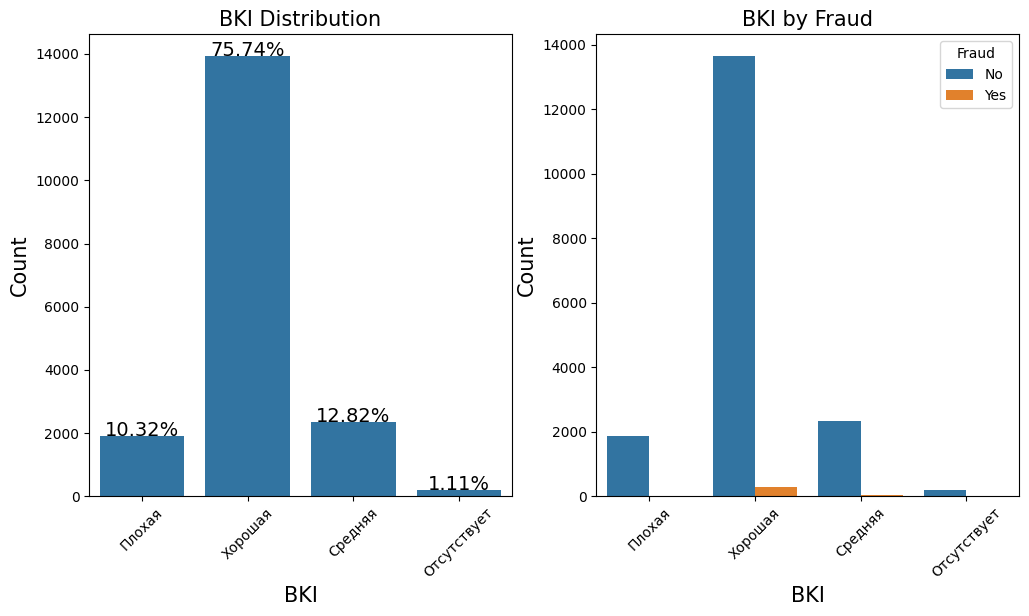

In [41]:
plt.figure(figsize=(12,6))

total = len(df_cat)

plt.subplot(121)
g = sns.countplot(x = 'BKI', data = df_cat)
g.set_title('BKI Distribution', fontsize = 15)
g.set_xlabel("BKI", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
plt.subplot(122)
g1 = sns.countplot(x='BKI', hue='target', data=df_merged)
g1.set_title('BKI by Fraud', fontsize = 15)
g1.set_xlabel("BKI", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
g1.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

In [23]:
print(df_merged[df_merged['target'] == 1]['BKI'].value_counts(normalize = True))
print("  ")
print(df_merged.groupby('BKI')['target'].value_counts(normalize = True))

BKI
Хорошая        0.817647
Средняя        0.085294
Отсутствует    0.055882
Плохая         0.041176
Name: proportion, dtype: float64
  
BKI          target
Отсутствует  0         0.907317
             1         0.092683
Плохая       0         0.992620
             1         0.007380
Средняя      0         0.987701
             1         0.012299
Хорошая      0         0.980037
             1         0.019963
Name: proportion, dtype: float64


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Отсутствует'),
  Text(1, 0, 'Плохая'),
  Text(2, 0, 'Средняя'),
  Text(3, 0, 'Хорошая')])

<Figure size 1200x1200 with 0 Axes>

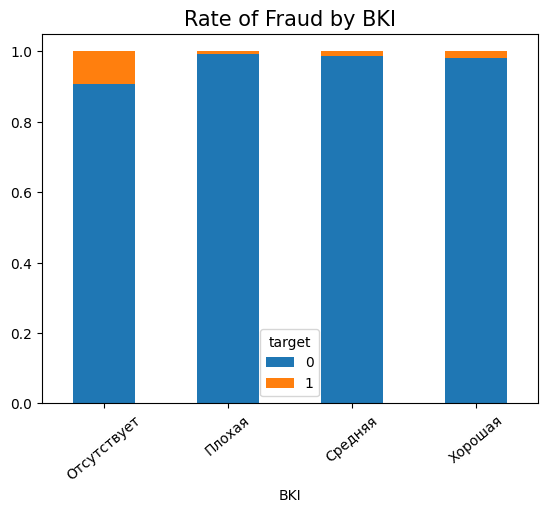

In [50]:
plt.figure(figsize=(12,12))
a = df_merged.groupby('BKI')['target'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
a.set_title('Rate of Fraud by BKI', fontsize = 15)
plt.xticks(rotation=40)

Признак BKI (кредитная история) показывает четкую зависимость с вероятностью фрода:

- Заявки с отсутствующей кредитной историей ("Отсутствует") имеют наиболее высокий уровень фрода — визуально заметное отличие.
- Заявки с "Плохой", "Средней" и "Хорошей" историей — фрод минимален.

BKI — сильный индикатор риска: отсутствие кредитной истории заметно увеличивает вероятность фрода. Признак однозначно следует включить в модель (в том числе как бинарную фичу IS_BKI_MISSING).

**Рассмотрим категорийный атрибут VKI-внутрення кредитная история** 

/tmp/ipykernel_2575/4073437403.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45)
/tmp/ipykernel_2575/4073437403.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g1.set_xticklabels(g.get_xticklabels(), rotation=45)


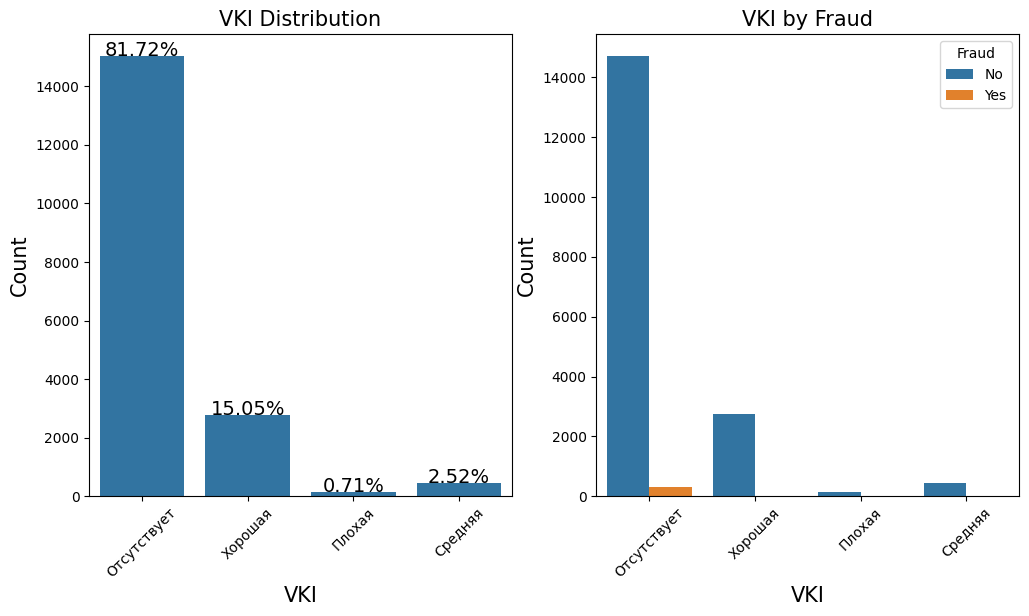

In [46]:
plt.figure(figsize=(12,6))

total = len(df_cat)

plt.subplot(121)
g = sns.countplot(x = 'VKI', data = df_cat)
g.set_title('VKI Distribution', fontsize = 15)
g.set_xlabel("VKI", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
plt.subplot(122)
g1 = sns.countplot(x='VKI', hue='target', data=df_merged)
g1.set_title('VKI by Fraud', fontsize = 15)
g1.set_xlabel("VKI", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
g1.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

In [51]:
print(df_merged[df_merged['target'] == 1]['VKI'].value_counts(normalize = True))
print(df_merged.groupby('VKI')['target'].value_counts(normalize = True))

VKI
Отсутствует    0.947059
Хорошая        0.044118
Средняя        0.008824
Name: proportion, dtype: float64
VKI          target
Отсутствует  0         0.978569
             1         0.021431
Плохая       0         1.000000
Средняя      0         0.993521
             1         0.006479
Хорошая      0         0.994581
             1         0.005419
Name: proportion, dtype: float64


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Отсутствует'),
  Text(1, 0, 'Плохая'),
  Text(2, 0, 'Средняя'),
  Text(3, 0, 'Хорошая')])

<Figure size 1200x1200 with 0 Axes>

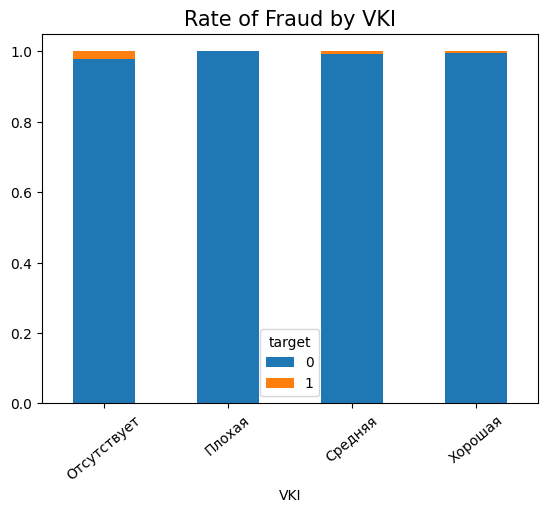

In [59]:
plt.figure(figsize=(12,12))
a = df_merged.groupby('VKI')['target'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
a.set_title('Rate of Fraud by VKI', fontsize = 15)
plt.xticks(rotation=40)

VKI аналогично c BKI

**Рассмотрим атрибут MARITALSTATUS**

/tmp/ipykernel_2575/626350488.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45)
/tmp/ipykernel_2575/626350488.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g1.set_xticklabels(g.get_xticklabels(), rotation=45)


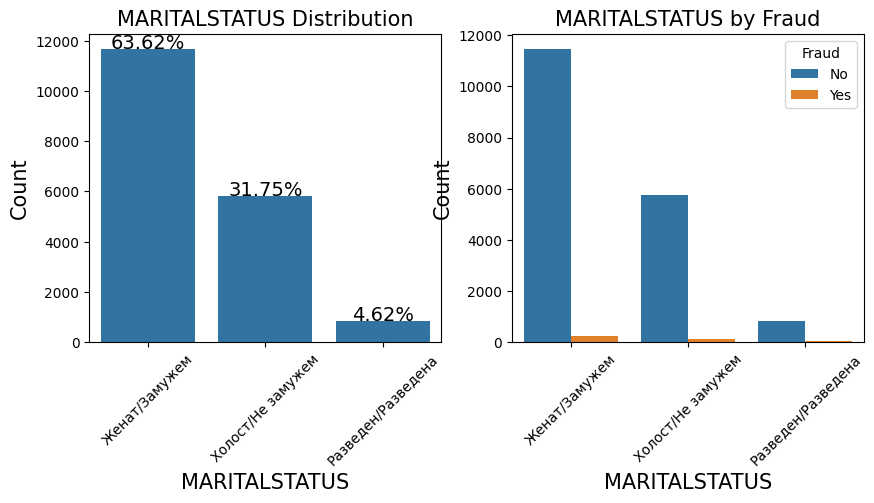

In [13]:
plt.figure(figsize=(10,4))

total = len(df_cat)

plt.subplot(121)
g = sns.countplot(x = 'MARITALSTATUS', data = df_cat)
g.set_title('MARITALSTATUS Distribution', fontsize = 15)
g.set_xlabel("MARITALSTATUS", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
plt.subplot(122)
g1 = sns.countplot(x='MARITALSTATUS', hue='target', data=df_merged)
g1.set_title('MARITALSTATUS by Fraud', fontsize = 15)
g1.set_xlabel("MARITALSTATUS", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
g1.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

In [60]:
print(df_merged[df_merged['target'] == 1]['MARITALSTATUS'].value_counts(normalize = True))
print("  ")
df_merged.groupby('MARITALSTATUS')['target'].value_counts(normalize = True)

MARITALSTATUS
Женат/Замужем         0.632353
Холост/Не замужем     0.282353
Разведен/Разведена    0.085294
Name: proportion, dtype: float64
  


MARITALSTATUS       target
Женат/Замужем       0         0.981621
                    1         0.018379
Разведен/Разведена  0         0.965882
                    1         0.034118
Холост/Не замужем   0         0.983556
                    1         0.016444
Name: proportion, dtype: float64

(array([0, 1, 2]),
 [Text(0, 0, 'Женат/Замужем'),
  Text(1, 0, 'Разведен/Разведена'),
  Text(2, 0, 'Холост/Не замужем')])

<Figure size 1200x1200 with 0 Axes>

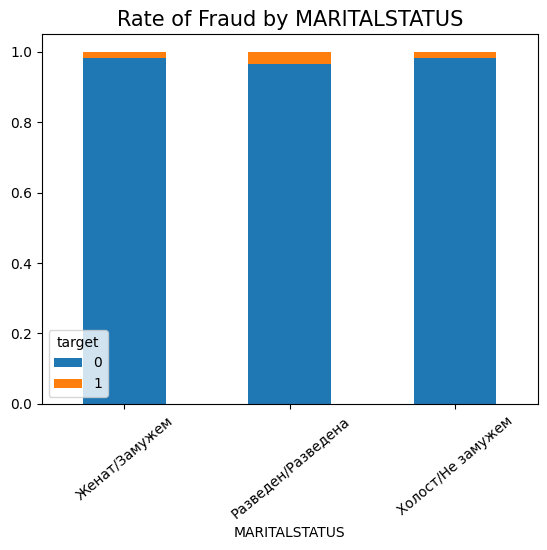

In [16]:
# visualization of table
plt.figure(figsize=(12,12))
a = df_merged.groupby('MARITALSTATUS')['target'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
a.set_title('Rate of Fraud by MARITALSTATUS', fontsize = 15)
plt.xticks(rotation=40)

### Гипотеза - Разведенные люди более подвержены фроду  
Категория "Разведен/Разведена" имеет самую высокую долю фрода — 3.41%, что почти в 2 раза выше, чем у остальных групп.

Несмотря на то, что эта категория составляет всего 8.5% от выборки, она может быть значимым предиктором фрода.

Остальные группы (Женат, Холост) имеют схожую и относительно низкую фрод-частоту.



**Рассмотрим атрибуты по Геоданным**

In [24]:
for col in ['REGCOUNTY', 'REGREGION', 'REGTOWN', 'BIRTHCOUNTRY']:
    stats = df_merged.groupby(col)['target'].agg(['count', 'sum', 'mean']).sort_values(by='mean', ascending=False)
    print(f"\n📌 Feature: {col}")
    print(f"✅ Уникальных значений: {df_merged[col].nunique()}")
    print(f"🔍 Средний fraud rate: {df_merged.groupby(col)['target'].mean().mean():.4f}")
    print(f"📈 Топ по fraud rate:\n{stats.head(5)}")



📌 Feature: REGCOUNTY
✅ Уникальных значений: 18
🔍 Средний fraud rate: 0.0202
📈 Топ по fraud rate:
                                 count  sum      mean
REGCOUNTY                                            
Акмолинская область                587   24  0.040886
Западно-Казахстанская область      610   20  0.032787
С-Казахстанская область            338   11  0.032544
Восточно- Казахстанская область    629   18  0.028617
Павлодарская область               743   21  0.028264

📌 Feature: REGREGION
✅ Уникальных значений: 195
🔍 Средний fraud rate: 0.0249
📈 Топ по fraud rate:
                        count  sum      mean
REGREGION                                   
Район Шал акына             7    2  0.285714
Иртышский район             4    1  0.250000
Шортандинский район        21    5  0.238095
Буландынский район         14    3  0.214286
район Беимбета Майлина     13    2  0.153846

📌 Feature: REGTOWN
✅ Уникальных значений: 323
🔍 Средний fraud rate: 0.0333
📈 Топ по fraud rate:
             

In [25]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

for col in ['REGCOUNTY', 'REGREGION', 'REGTOWN', 'BIRTHCOUNTRY']:
    v = cramers_v(df_merged[col], df_merged['target'])
    print(f"Cramér’s V for {col}: {v:.4f}")


Cramér’s V for REGCOUNTY: 0.0528
Cramér’s V for REGREGION: 0.1711
Cramér’s V for REGTOWN: 0.2112
Cramér’s V for BIRTHCOUNTRY: 0.0383


| Признак        | Cramér’s V | Интерпретация                      |
| -------------- | ---------- | ---------------------------------- |
| `REGCOUNTY`    | **0.0528** | 💡 Низкая, но допустимая связь     |
| `REGREGION`    | **0.1711** | ✅ Умеренная связь (можно оставить) |
| `REGTOWN`      | **0.2112** | ✅ Сильнее всех, сигнал есть        |
| `BIRTHCOUNTRY` | **0.0383** | ❌ Очень слабая, почти шум          |


| Признак        | Что делать                                   | Почему                          |
| -------------- | -------------------------------------------- | ------------------------------- |
| `REGCOUNTY`    | ✅ Можно оставить                             | Низкая кардинальность (18 обл.) |
| `REGREGION`    | ✅ Оставить + агрегация (если нужно)          | Умеренная связь                 |
| `REGTOWN`      | ✅ Только с агрегацией (например, `is_rural`) | Иначе переобучение (323 знач.)  |
| `BIRTHCOUNTRY` | ❌ Удалить или превратить в `is_foreign_born` | почти всё — Казахстан           |


Рассмотрим численные фичи

/tmp/ipykernel_8877/1579813446.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette="crest")
/tmp/ipykernel_8877/1579813446.py:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/audioenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


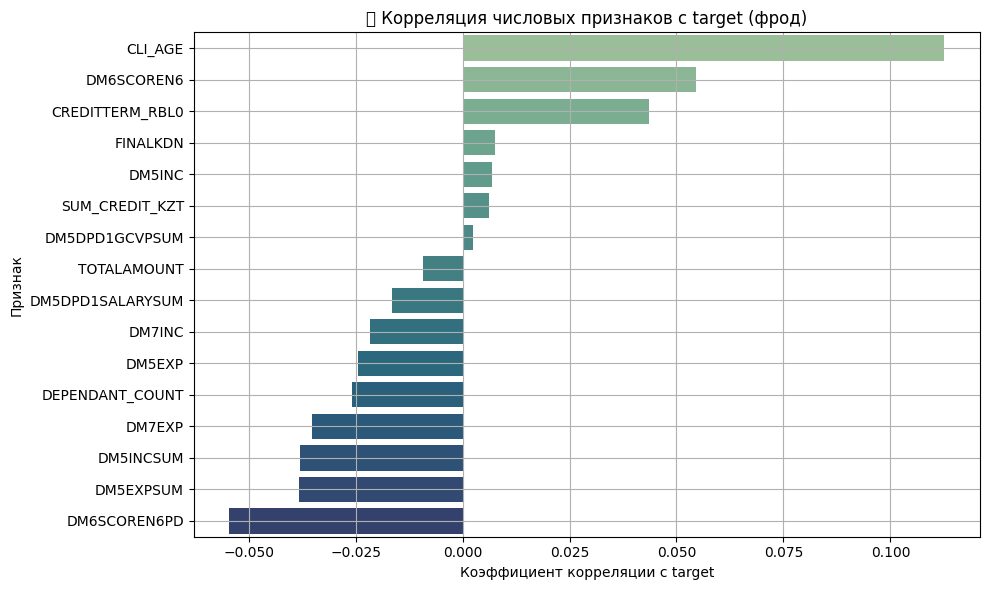

In [40]:
correlations = df_merged[numeric_cols + ['target']].corr()['target'].drop('target').sort_values(ascending=False)

# Шаг 4: визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette="crest")
plt.title("📊 Корреляция числовых признаков с target (фрод)")
plt.xlabel("Коэффициент корреляции с target")
plt.ylabel("Признак")
plt.grid(True)
plt.tight_layout()
plt.show()

| Признак           | Корреляция | Вывод                          |
| ----------------- | ---------- | ------------------------------ |
| `CLI_AGE`         | +0.105     | Явный сигнал: возраст влияет |
| `DM6SCOREN6`      | +0.08+     | PD, расчитанный в СПР значим      |
| `CREDITTERM_RBL0` | +0.05      | Срок кредита (мес) умеренно полезен            |
| `FINALKDN`        | +0.03\~    | Возможен слабый вклад       |


/tmp/ipykernel_8877/1718705903.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_fraud_rate = df_merged.groupby('AGE_GROUP')['target'].mean()
/tmp/ipykernel_8877/1718705903.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_fraud_rate.index, y=age_fraud_rate.values, palette="flare")
/tmp/ipykernel_8877/1718705903.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/audioenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


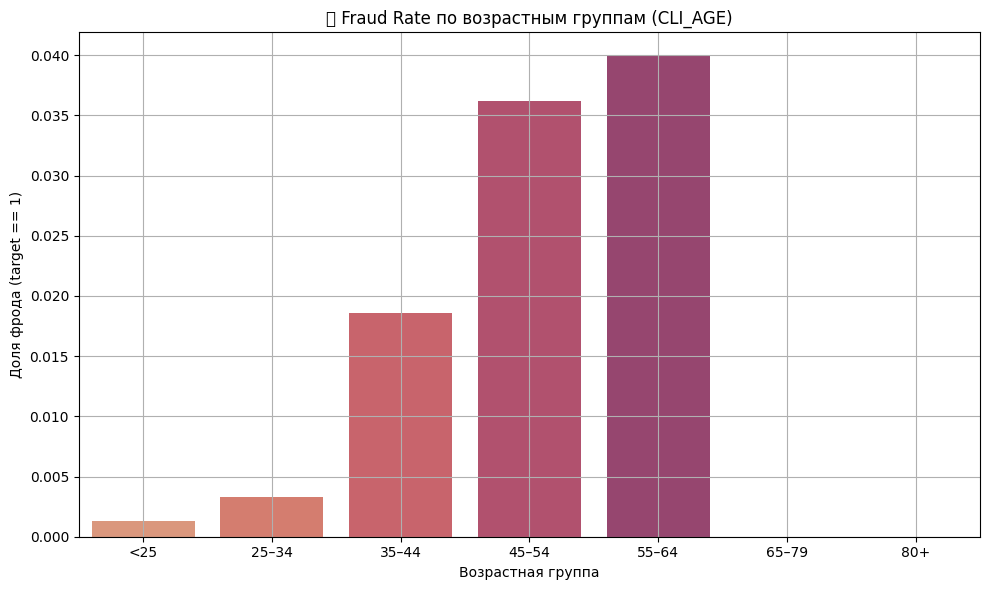

In [41]:
# Категоризация возраста по группам
bins = [0, 25, 35, 45, 55, 65, 80, 100]
labels = ['<25', '25–34', '35–44', '45–54', '55–64', '65–79', '80+']
df_merged['AGE_GROUP'] = pd.cut(df_merged['CLI_AGE'], bins=bins, labels=labels, right=False)

# Группировка и подсчёт фрод-рейта
age_fraud_rate = df_merged.groupby('AGE_GROUP')['target'].mean()

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x=age_fraud_rate.index, y=age_fraud_rate.values, palette="flare")
plt.title("📊 Fraud Rate по возрастным группам (CLI_AGE)")
plt.xlabel("Возрастная группа")
plt.ylabel("Доля фрода (target == 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

Группы 45–54 и 55–64 имеют самые высокие фрод-рейты
Младше 35 лет и старше 65 лет — почти не вовлечены в мошенничество

/tmp/ipykernel_8877/3152986228.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_dependants.index, y=fraud_by_dependants.values, palette="rocket")
/tmp/ipykernel_8877/3152986228.py:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/audioenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


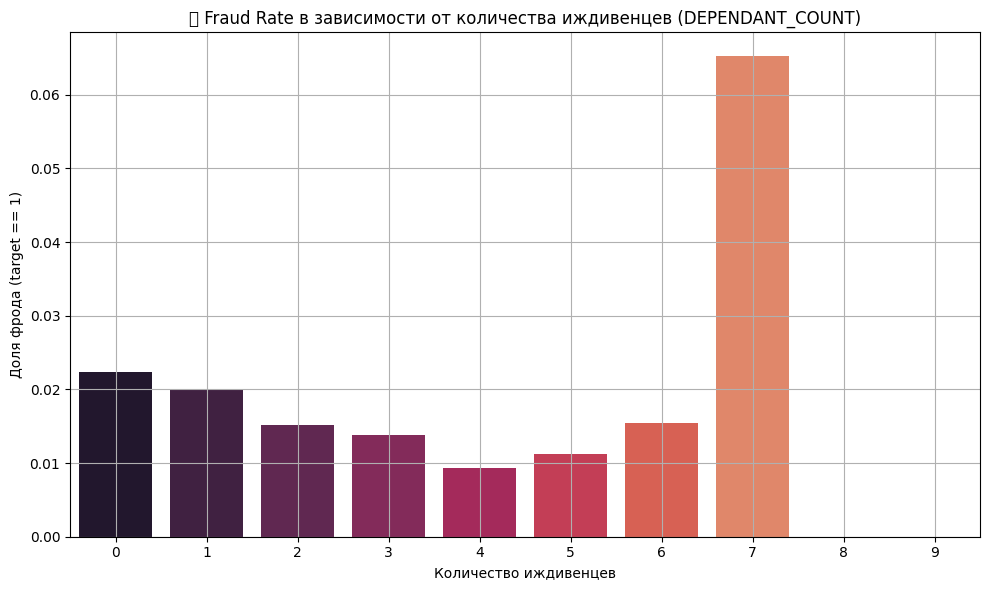

In [42]:
# Подсчёт fraud rate на каждый уровень количества иждивенцев
fraud_by_dependants = df_merged.groupby('DEPENDANT_COUNT')['target'].mean()

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_dependants.index, y=fraud_by_dependants.values, palette="rocket")
plt.title("📊 Fraud Rate в зависимости от количества иждивенцев (DEPENDANT_COUNT)")
plt.xlabel("Количество иждивенцев")
plt.ylabel("Доля фрода (target == 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

Низкая нелинейная зависимость. Аномальный всплеск при 7 иждивенцах. Скорее всего это может быть шумом или выбросом, а не устойчивым паттерном. Даже у клиентов с 0 иждивенцев fraud-rate выше, чем у тех, у кого 2–5

In [43]:
df_merged['DEPENDANT_COUNT'].max()

np.int64(9)

Расммотрим Долю фрод кейсов по запрошенной сумме

/tmp/ipykernel_8877/1902090062.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_dist = df_merged.groupby(['credit_range', 'target']).size().unstack(fill_value=0)
/tmp/ipykernel_8877/1902090062.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/audioenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


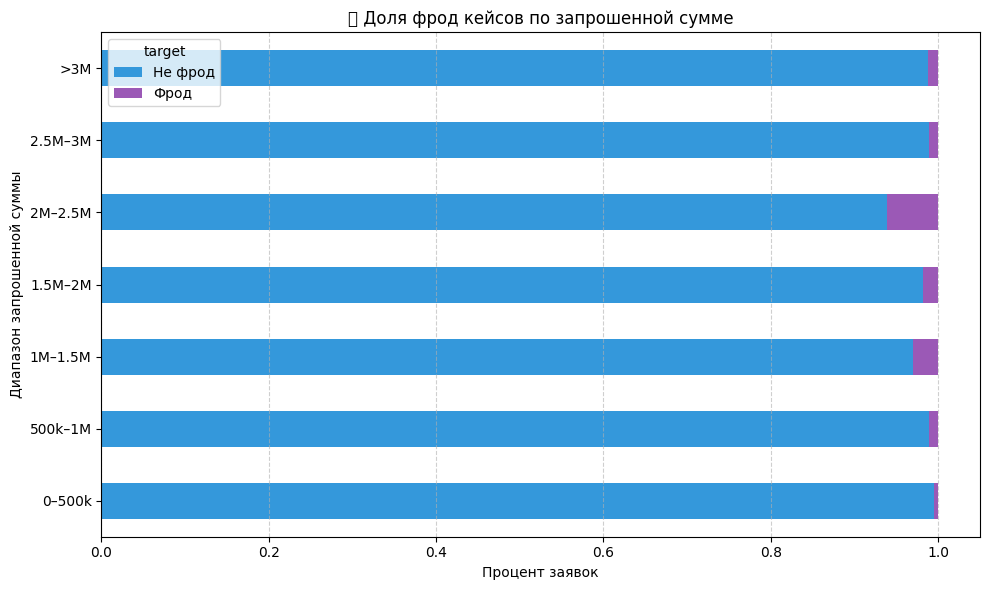

In [34]:
# 1. Создаем диапазоны (bins) и метки
bins = [0, 500_000, 1_000_000, 1_500_000, 2_000_000, 2_500_000, 3_000_000, float('inf')]
labels = ['0–500k', '500k–1M', '1M–1.5M', '1.5M–2M', '2M–2.5M', '2.5M–3M', '>3M']

# 2. Классифицируем суммы по диапазонам
df_merged['credit_range'] = pd.cut(df_merged['TOTALAMOUNT'], bins=bins, labels=labels, right=False)

# 3. Группируем по диапазону и таргету
fraud_dist = df_merged.groupby(['credit_range', 'target']).size().unstack(fill_value=0)

# 4. Переводим в проценты
fraud_percent = fraud_dist.div(fraud_dist.sum(axis=1), axis=0)

# 5. Визуализация
fraud_percent.plot(kind='barh', stacked=True, color=['#3498db', '#9b59b6'], figsize=(10,6))

plt.title('📊 Доля фрод кейсов по запрошенной сумме')
plt.xlabel('Процент заявок')
plt.ylabel('Диапазон запрошенной суммы')
plt.legend(['Не фрод', 'Фрод'], title='target')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/tmp/ipykernel_8877/3227470937.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_dist = df_merged.groupby(['credit_range', 'target']).size().unstack(fill_value=0)
/tmp/ipykernel_8877/3227470937.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/audioenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


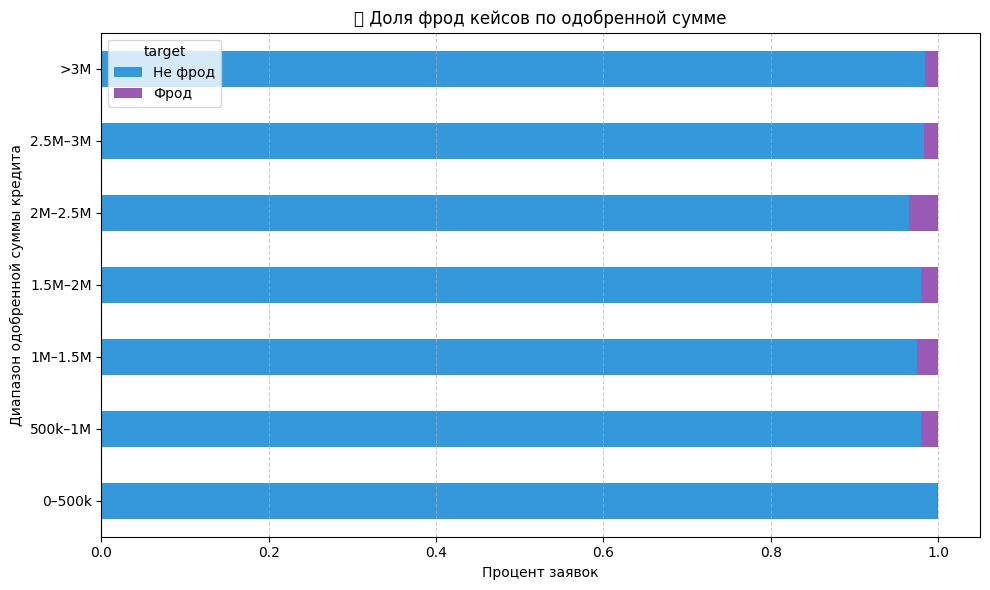

In [35]:
# 1. Создаем диапазоны (bins) и метки
bins = [0, 500_000, 1_000_000, 1_500_000, 2_000_000, 2_500_000, 3_000_000, float('inf')]
labels = ['0–500k', '500k–1M', '1M–1.5M', '1.5M–2M', '2M–2.5M', '2.5M–3M', '>3M']

# 2. Классифицируем суммы по диапазонам
df_merged['credit_range'] = pd.cut(df_merged['SUM_CREDIT_KZT'], bins=bins, labels=labels, right=False)

# 3. Группируем по диапазону и таргету
fraud_dist = df_merged.groupby(['credit_range', 'target']).size().unstack(fill_value=0)

# 4. Переводим в проценты
fraud_percent = fraud_dist.div(fraud_dist.sum(axis=1), axis=0)

# 5. Визуализация
fraud_percent.plot(kind='barh', stacked=True, color=['#3498db', '#9b59b6'], figsize=(10,6))

plt.title('📊 Доля фрод кейсов по одобренной сумме')
plt.xlabel('Процент заявок')
plt.ylabel('Диапазон одобренной суммы кредита')
plt.legend(['Не фрод', 'Фрод'], title='target')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Мошенники адаптируют поведение под "золотую середину" — запрашивают суммы, которые:
- достаточно крупные, чтобы быть выгодными;
- но достаточно реалистичные, чтобы пройти скоринг и антифрод-фильтры.

Рекомендации:
- Ввести фичу `IS_SUSPICIOUS_AMOUNT` = 1, если сумма заявки/одобрения попадает в диапазон **1M–2.5M KZT**.
- Усилить антифрод-проверки в этом диапазоне (например, дополнительные звонки, биометрия, аудиоконтроль).


Рассмотрим атрибут MNG_NAME_LOGIN_INIT


In [38]:
df_merged['IS_SERVWS_MNLI'] = (df_merged['MNG_NAME_LOGIN_INIT'] == 'servws').astype(int)
cat_cols.append('IS_SERVWS_MNLI')
df_cat = df_merged[cat_cols]
print(df_merged['IS_SERVWS_MNLI'].value_counts())
print(df_merged[df_merged['target'] == 1]['IS_SERVWS_MNLI'].value_counts(normalize = True))

IS_SERVWS_MNLI
1    13581
0     4805
Name: count, dtype: int64
IS_SERVWS_MNLI
1    0.964706
0    0.035294
Name: proportion, dtype: float64


In [36]:
df_merged[['IS_SERVWS_MNLI', 'target']].corr()

,IS_SERVWS_MNLI,target
IS_SERVWS_MNLI,1.000000,0.070619
target,0.070619,1.000000


/tmp/ipykernel_8877/2336078146.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/audioenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


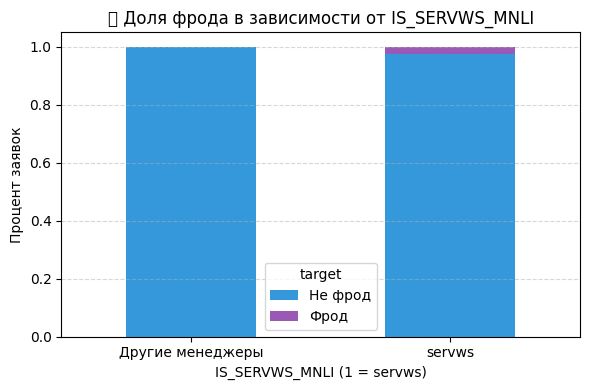

In [37]:
# Таблица с абсолютными значениями
counts = pd.crosstab(df_merged['IS_SERVWS_MNLI'], df_merged['target'])

# Перевод в проценты по строкам (нормализация)
percentages = counts.div(counts.sum(axis=1), axis=0)

# Построение stacked bar
percentages.plot(kind='bar', stacked=True, color=['#3498db', '#9b59b6'], figsize=(6, 4))

plt.title('📊 Доля фрода в зависимости от IS_SERVWS_MNLI')
plt.xlabel('IS_SERVWS_MNLI (1 = servws)')
plt.ylabel('Процент заявок')
plt.xticks(ticks=[0, 1], labels=['Другие менеджеры', 'servws'], rotation=0)
plt.legend(title='target', labels=['Не фрод', 'Фрод'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Признак IS_SERVWS_MNLI (Логин менеджера для QR) оказался информативным:

Доля фрода у других менеджеров (IS_SERVWS_MNLI = 0): 0.25%

Доля фрода у servws (IS_SERVWS_MNLI = 1): 2.42%

📈 Это в ~10 раз выше, чем у остальных.

Системный servws -  явно выделяется как связанный с повышенной вероятностью фродовых заявок.
Вывод - MNG_NAME_LOGIN_INIT - это скорее система, тогда как остальные u** - проходят проверку менеджером, в связи с чем в случаях где MNG_NAME_LOGIN_INIT - servws фрод кейсов больше. 